# Log visualisation


In [1]:
%load_ext tensorboard

In [7]:
%tensorboard --logdir runs/pong_original_4408c85/ --port 6007


Reusing TensorBoard on port 6007 (pid 139328), started 0:00:03 ago. (Use '!kill 139328' to kill it.)

In [5]:
!kill 72726


In [3]:
# Training of movingodt
%tensorboard --logdir runs/PongSynth_3fca07c/



ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [4]:
%tensorboard --logdir runs/1738594711_4408c85 --port 6008


## Show the networks

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

from reward_predictor_core_network import net_cnn, net_moving_dot_features
import visualkeras

In [2]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from collections import defaultdict

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[ZeroPadding2D]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

#visualkeras.layered_view(model, color_map=color_map)

In [12]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),
    Dense(64, activation='relu'),
    Dense(1)    
])
visualkeras.layered_view(model, color_map=color_map)

/home/waddason/miniconda3/envs/py3.7/lib/python3.7/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [3]:
batchnorm =  True
dropout = 0.5
training = False

model = Sequential()
model.add(layers.InputLayer(input_shape=(84, 84, 4)))  # Assuming input shape is (height, width, channels)
model.add(layers.Lambda(lambda x: x / 255.0))
model.add(visualkeras.SpacingDummyLayer())
model.add(layers.Conv2D(16, (7, 7), strides=3, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
if batchnorm:
    model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout))
model.add(visualkeras.SpacingDummyLayer())
model.add(layers.Conv2D(16, (5, 5), strides=2, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
if batchnorm:
    model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout))
model.add(visualkeras.SpacingDummyLayer())
model.add(layers.Conv2D(16, (3, 3), strides=1, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
if batchnorm:
    model.add(layers.BatchNormalization())
model.add(layers.Dropout(dropout))
model.add(visualkeras.SpacingDummyLayer())
model.add(layers.Conv2D(16, (3, 3), strides=1, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
if batchnorm:
    model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/home/waddason/miniconda3/envs/py3.7/lib/python3.7/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


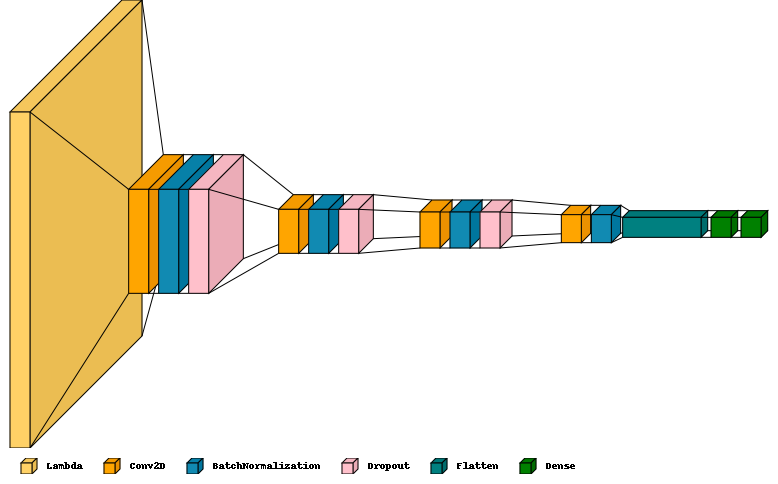

In [4]:
from PIL import ImageFont

font = ImageFont.truetype("/home/waddason/.local/share/fonts/InconsolataNerdFontMono-Regular.ttf", 14)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, color_map=color_map, legend=True, to_file="/home/waddason/Documents/Git_Reps/M2DS_2024-2025/20.Reinforcement-learning/Project 2024/ProjectReport/figures/NN_reward_predictor.png")

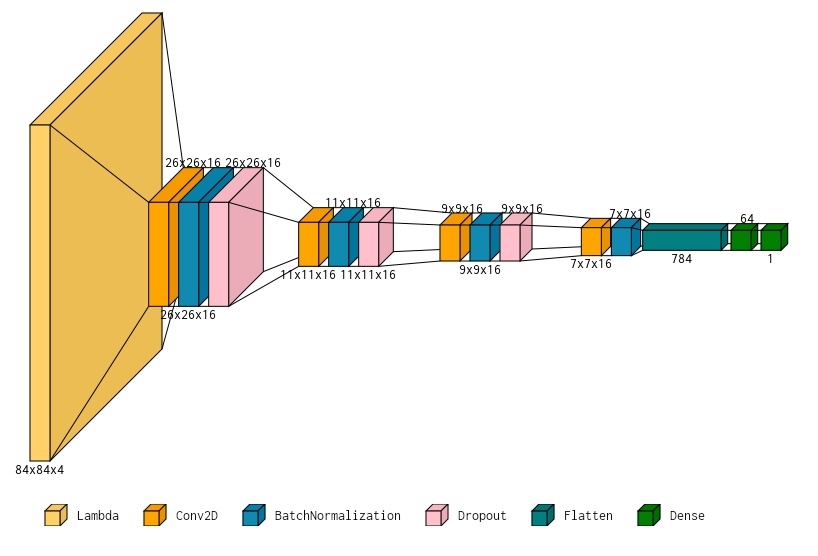

In [5]:
def text_callable(layer_index, layer):
    # Every other piece of text is drawn above the layer, the first one below
    above = bool(layer_index%2)


    # Get the output shape of the layer
    output_shape = [x for x in list(layer.output_shape) if x is not None]

    # If the output shape is a list of tuples, we only take the first one
    if isinstance(output_shape[0], tuple):
        output_shape = list(output_shape[0])
        output_shape = [x for x in output_shape if x is not None]

    # Variable to store text which will be drawn    
    output_shape_txt = ""

    # Create a string representation of the output shape
    for ii in range(len(output_shape)):
        output_shape_txt += str(output_shape[ii])
        if ii < len(output_shape) - 1: # Add an x between dimensions, e.g. 3x3
            output_shape_txt += "x"
        #if ii == len(output_shape) - 2: # Add a newline between the last two dimensions, e.g. 3x3 \n 64
        #    output_shape_txt += "\n"

    # Add the name of the layer to the text, as a new line
    # output_shape_txt += f"\n{layer.name}"

    # Return the text value and if it should be drawn above the layer
    return output_shape_txt, above

to_file="/home/waddason/Documents/Git_Reps/M2DS_2024-2025/20.Reinforcement-learning/Project 2024/ProjectReport/figures/NN_reward_predictor_with_dim.png"

visualkeras.layered_view(model, padding=30, font=font, color_map=color_map, text_callable=text_callable, legend=True, to_file=to_file)

In [6]:
from tf_agents.distributions import gumbel_softmax
class CnnPolicy(object):
    """Modèle définit pour Pong dans le fichier a2c.a2c.policies.py
        Transformé pour être visualisé avec visualkeras"""

    def __init__(self, sess, ob_space, ac_space, nenv, nsteps, nstack, reuse=False):
        nbatch = nenv * nsteps
        nh, nw, nc = ob_space.shape
        ob_shape = (nbatch, nh, nw, nc * nstack)
        nact = ac_space.n
        X = tf.placeholder(tf.uint8, ob_shape)  # obs

        model = Sequential()
        model.add(layers.InputLayer(input_shape=(nh, nw, nc * nstack)))
        model.add(layers.Lambda(lambda x: tf.cast(x, tf.float32) / 255.0))
        model.add(visualkeras.SpacingDummyLayer())
        model.add(layers.Conv2D(32, (8, 8), strides=4, activation='relu'))
        model.add(visualkeras.SpacingDummyLayer())
        model.add(layers.Conv2D(32, (8, 8), strides=4, activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(512, activation='relu'))
        model.add(layers.Dense(6, activation=None))
        model.add(layers.Dense(1, activation=None))

        self.model = model

In [9]:
import gym
import numpy as np
sess = tf.Session()
ob_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 4), dtype=np.uint8)
ac_space = gym.spaces.Discrete(6)
nenv = 16
nsteps = 10
nstack = 4

model = CnnPolicy(sess, ob_space, ac_space, nenv, 1, nstack, reuse=False)


2025-02-05 23:35:37.039464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-02-05 23:35:37.039479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      


AttributeError: module 'gym' has no attribute 'spaces'

In [10]:
to_file="/home/waddason/Documents/Git_Reps/M2DS_2024-2025/20.Reinforcement-learning/Project 2024/ProjectReport/figures/NN_policy_dim.png"

visualkeras.layered_view(model.model, color_map=color_map, padding=30, font=font,text_callable=text_callable, legend=True, to_file=to_file)

AttributeError: 'Sequential' object has no attribute 'model'

In [11]:
font= ImageFont.truetype("/home/waddason/.local/share/fonts/InconsolataNerdFontMono-Regular.ttf", 16)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model.model, padding=30, font=font, color_map=color_map, text_callable=text_callable, legend=True)

AttributeError: 'Sequential' object has no attribute 'model'